# Think Bayes: Chapter 8

This notebook presents code and exercises from Think Bayes, second edition.

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from sympy import symbols
import math
import matplotlib.pyplot as plt
import mythinkbayes as mtb
import numpy as np
import pandas as pd
import pdb
import scipy.stats
import sys

sys.path.append('.')

'Done'

'Done'

## Red Line Problem 

The model computes a distribution of wait times based on the number of people seen waiting at Kendall Square.

Based on this distribution  and some fixed rules about subsequent transportation, we make a decision to either wait for the Red Line or take a taxi.

## Model

- Time window: we assume that the model only applies to the peak traffic period of time when people are leaving work.
- Passenger arrival are a poisson process. Passengers are equally likely to arrive at any time and arrive at an unknown rate, $\lambda$
- Train arrival intervals are normally distributed. Trains start every 7 to 8 minutes, but arrive at Kendall Square 3 to 12 minutes apart.

### Notation

- $Z$: train arrival interval.
- $Z_b$: observer-biased train arrival interval.
- $Y$: wait time, the time between the arrival of a passenger and the next train arrival.
- $X$: elapsed time, the time between the arrival of the previous train and the arrival of a passenger.

```

Train n arrives ------ X ------> Passenger arrives ------ Y ------> Train n+1 arrives
                ------------------------ Z ----------------------->

```

## Observer Bias

The interval between trains is variable. Intuitively, more people will arrive during a ten minute interval than a five minute interval.

Thus, if you ask all people to tell you the size of the interval during which they arrived, the resulting distribution will be biased to larger intervals.

It's critical to understand that we are talking strictly about the full interval between trains, and not the amount of time spent waiting. See [this github issue](https://github.com/AllenDowney/ThinkBayes/issues/13) for more detail on the potential ambiguity.

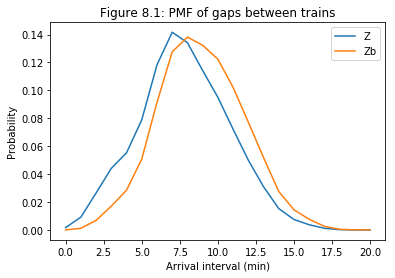

In [2]:
# observed gaps between trains, in seconds
# collected using code in redline_data.py, run daily 4-6pm
# for 5 days, Monday 6 May 2013 to Friday 10 May 2013
OBSERVED_GAP_TIMES = np.array([
    428.0, 705.0, 407.0, 465.0, 433.0, 425.0, 204.0, 506.0, 143.0, 351.0,
    450.0, 598.0, 464.0, 749.0, 341.0, 586.0, 754.0, 256.0, 378.0, 435.0,
    176.0, 405.0, 360.0, 519.0, 648.0, 374.0, 483.0, 537.0, 578.0, 534.0,
    577.0, 619.0, 538.0, 331.0, 186.0, 629.0, 193.0, 360.0, 660.0, 484.0,
    512.0, 315.0, 457.0, 404.0, 740.0, 388.0, 357.0, 485.0, 567.0, 160.0,
    428.0, 387.0, 901.0, 187.0, 622.0, 616.0, 585.0, 474.0, 442.0, 499.0,
    437.0, 620.0, 351.0, 286.0, 373.0, 232.0, 393.0, 745.0, 636.0, 758.0,
]) / 60

MAX_MINS_WAIT = 20

Z = mtb.PMF.from_kde(OBSERVED_GAP_TIMES, np.arange(MAX_MINS_WAIT + 1))
Zb = mtb.PMF(Z.hypos, Z.probs * Z.hypos)

Z.plot(label='Z')
Zb.plot(label='Zb')
plt.title('Figure 8.1: PMF of gaps between trains')
plt.xlabel('Arrival interval (min)')
plt.ylabel('Probability')
plt.legend()
plt.show()

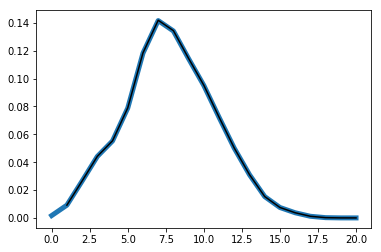

In [3]:
# # How to unbias the PMF.
Zub = mtb.PMF(Zb.hypos, Zb.probs / Zb.hypos)
Z.plot(linewidth=5)
Zub.plot(color='black')
plt.show()

## Wait Times

The analytic definition of waiting times, $Y$, looks like this:

$Z_b = X + Y \\ Y = Z_b - X$

Alternatively, $Y$ can be computed as a mixture of uniform random variables weighted by the entries in $Z_b$. For example, if $P_{Z_b}(4) = 0.2$, then a 4-minute interval has probability 0.2 and the mixture will include $U(0, 4)$ with weight $0.2$.

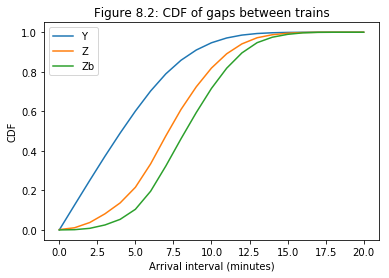

E[Z] = 7.770
E[Zb] = 8.897
E[Y] = 5.007


In [4]:
def make_Y_from_Z(Z):
    Zb = mtb.PMF(Z.hypos, Z.probs * Z.hypos)
    
    pmfs = [
        (mtb.PMF(range(interval + 1)), prob)
        for interval, prob in Zb.items()
    ]
    
    for pmf, weight in pmfs:
        pmf[0] *= 0
    
    return mtb.PMF.from_mixture(pmfs)
    
Y = make_Y_from_Z(Z)
Y.to_cdf().plot(label='Y')
Z.to_cdf().plot(label='Z')
Zb.to_cdf().plot(label='Zb')
plt.title('Figure 8.2: CDF of gaps between trains')
plt.xlabel('Arrival interval (minutes)')
plt.ylabel('CDF')
plt.legend()
plt.show()

print('E[Z] = %.3lf' % Z.expectation())
print('E[Zb] = %.3lf' % Zb.expectation())
print('E[Y] = %.3lf' % Y.expectation())

# Check against Downey's results from book.
tol = 1
assert abs(Z.expectation() - 7.7) < tol
assert abs(Zb.expectation() - 8.8) < tol
assert abs(Y.expectation() - 4.4) < tol

## Predicting Wait Times

> Suppose that when I arrive at the platform I see 10 people waiting. How long should I expect to wait until the next train arrives?

### Assuming a fixed value for $\lambda$ is given

1. Use the distribution of $Z$ to get the prior of $Z_b$.
2. Use the number of passengers to estimate the distribution of $X$, the elapsed time since the last train measured when the passenger has arrived.
3. Use the relation $Z_b = X + Y, Y = Z_b - X$ to get the distribution of $Y$.

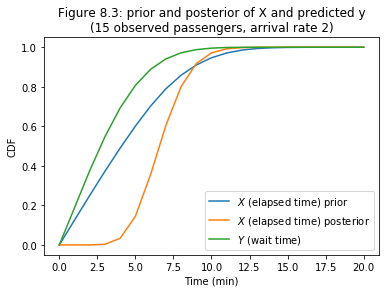

In [5]:
lam_passengers = 2  # 2 passengers per minute arriving on platform.
n_passengers = 15   # 15 passengers when we arrive.

class WaitTimeCalculator:
    """
    Given the actual distribution of gap times (Z),
    computes the distribution of gaps as seen by
    a random passenger (Zb), which yields the distribution
    of wait times (Y) and the distribution of elapsed times (X).
    """
    
    def __init__(self, Z):
        
        # Bias the Z PMF.
        self.Zb = mtb.PMF(Z.hypos, Z.hypos * Z.probs)
        
        # Make the mixture of wait times, Y.
        pmfs = [
            (mtb.PMF(range(int(interval) + 1)), prob)
            for interval, prob in self.Zb.items()
        ]
        
        for pmf, _ in pmfs:
            pmf[0] *= 0
        
        self.Y = mtb.PMF.from_mixture(pmfs)
        
        # The distribution of elapsed times, X.
        self.X = self.Y.copy()
        
class Elapsed(mtb.PMF):
    """Represents the distribution of elapsed time (X)."""

    def likelihood(self, data, hypo):
        """Compute the likelihood:
        P(number of passengers on platform | poisson arrival rate lambda, minutes since last train)
        
        The arrival rate lambda has unit: people / minute
        
        hypo: minutes since the last train
        data: tuple (lambda, number of passengers on platform)
        """
        
        mins_elapsed = hypo
        lam, n_passengers = data
        return scipy.stats.poisson.pmf(n_passengers, lam * mins_elapsed)
        
class ElapsedTimeCalculator:
    """Uses the number of passengers to estimate time since last train."""
    
    def __init__(self, wtc, lam_passengers=2, n_passengers=15):
        
        self.X_prior = Elapsed(wtc.X.hypos, wtc.X.probs)
        self.X_post = Elapsed(wtc.X.hypos, wtc.X.probs)
        self.X_post.update((lam_passengers, n_passengers))
        self.Y = wtc.Zb - self.X_post
        
        for h in self.Y.hypos:
            if h < 0:
                del self.Y[h]
            elif h == 0:
                self.Y[h] *= 0
        self.Y.normalize()

wtc = WaitTimeCalculator(Z)
etc = ElapsedTimeCalculator(wtc, lam_passengers, n_passengers)

etc.X_prior.to_cdf().plot(label='$X$ (elapsed time) prior')
etc.X_post.to_cdf().plot(label='$X$ (elapsed time) posterior')
etc.Y.to_cdf().plot(label='$Y$ (wait time)')
plt.ylabel('CDF')
plt.xlabel('Time (min)')
plt.title('Figure 8.3: prior and posterior of X and predicted y\n(%d observed passengers, arrival rate %d)' % (
    n_passengers, lam_passengers))
plt.legend()
plt.show()

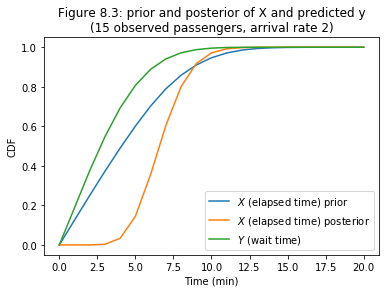

In [6]:
lam_passengers = 2  # 2 passengers per minute arriving on platform.
n_passengers = 15   # 15 passengers when we arrive.

class RedLineCalculator:
    
    """This combines the three classes WaitTimeCalculator, Elapsed, and ElapsedTimeCalculator
    into a single class."""
    
    def __init__(self, Z_historic):
        
        # PMF for Z: arrival intervals.
        lo, hi = 0, 2 * max(Z_historic)
        self.Z = mtb.PMF.from_kde(Z_historic, np.arange(lo, hi))
        
        # PMF for Zb: observer-biased Z.
        self.Zb = mtb.PMF(Z.hypos, Z.hypos * Z.probs)
        
        # PMF for X and Y: elapsed time and passenger waiting time.
        # This is computed as a weighted mixture of uniform 
        # distributions for the possible waiting times.
        pmfs = []
        for interval, prob in self.Zb.items():
            pmfs.append((mtb.PMF(range(interval + 1)), prob))
            pmfs[-1][0][0] *= 0
        
        self.X = mtb.PMF.from_mixture(pmfs)

    def estimate_Y(self, lam_passengers=2, n_passengers=15):
        """Estimates Y (waiting time) distribution given an arrival rate and number of passengers observed.
        
        # Arguments:
            lam_passengers: lambda for Poisson process of passenger arrivals (unit: passengers / minute).
            n_passengers: number of passengers observed on the platform.
            
        # Returns:
            Y: PMF over waiting times.
            X_post: posterior distribution of elapsed times.
        """
        
        X_post = self.X.copy()
        
        for elapsed_hypo, prob in X_post.items():
            # P(n_passengers | lambda, minutes elapsed hypothesis)
            like = scipy.stats.poisson.pmf(n_passengers, lam_passengers * elapsed_hypo)
            X_post[elapsed_hypo] *= like
            
        X_post.normalize()
        
        # Estimate Y from Zb and X posterior.
        # Remove negative values and normalize.
        Y = self.Zb - X_post
        for h in Y.hypos:
            if h < 0:
                del Y[h]
            elif h == 0:
                Y[h] *= 0
        
        return Y.normalize(), X_post
      
rlc = RedLineCalculator(OBSERVED_GAP_TIMES)
Y, X_post = rlc.estimate_Y(lam_passengers, n_passengers)
        
rlc.X.to_cdf().plot(label='$X$ (elapsed time) prior')
X_post.to_cdf().plot(label='$X$ (elapsed time) posterior')
Y.to_cdf().plot(label='$Y$ (wait time)')
plt.ylabel('CDF')
plt.xlabel('Time (min)')
plt.title('Figure 8.3: prior and posterior of X and predicted y\n(%d observed passengers, arrival rate %d)' % (
    n_passengers, lam_passengers))
plt.legend()
plt.show()

## Estimating the Arrival Rate

Now we want to represent the arrival rate, $\lambda$, as a distribution and plug it into the analysis.

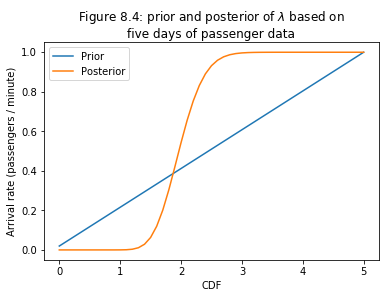

In [7]:
class ArrivalRate(mtb.PMF):
    
    def likelihood(self, data, hypo):
        lam = hypo   # Arrival rate (passengers per minute).
        y, k = data  # Wait time (minutes), # of passengers arrived during wait time.
        return scipy.stats.poisson.pmf(k, lam * y)
    
class ArrivalRateEstimator:
    
    def __init__(self, passenger_data):
        hypos = np.linspace(1e-7, 5, 51)
        self.lam_prior = ArrivalRate(hypos)
        self.lam_post = ArrivalRate(hypos)
        for _, y, k2 in passenger_data:
            self.lam_post.update((y, k2))


passenger_data = [
    (17, 4.6, 9),
    (22, 1, 0),
    (23, 1.4, 4),
    (18, 5.4, 12),
    (4, 5.8, 11)
]

are = ArrivalRateEstimator(passenger_data)

are.lam_prior.to_cdf().plot(label='Prior')
are.lam_post.to_cdf().plot(label='Posterior')
plt.title('Figure 8.4: prior and posterior of $\lambda$ based on\nfive days of passenger data')
plt.ylabel('Arrival rate (passengers / minute)')
plt.xlabel('CDF')
plt.legend()
plt.show()

## Incorporating Uncertainty

Make a mixture of $Y$ distributions from the $\lambda$ distributions.


3.6352274223795074


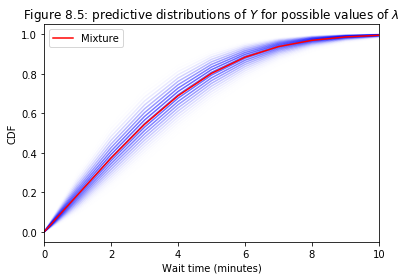

In [8]:
class WaitMixtureEstimator:
    
    def __init__(self, wtc, are, num_passengers=15):
        self.pmfs = []
        for lam, prob in are.lam_post.items():
            etc = ElapsedTimeCalculator(wtc, lam, num_passengers)
            self.pmfs.append((etc.Y, prob))
        self.mixture = mtb.PMF.from_mixture(self.pmfs)
        
wme = WaitMixtureEstimator(wtc, are)

for pmf, prob in wme.pmfs:
    cdf = pmf.to_cdf()
    plt.plot(cdf.hypos, cdf.probs, alpha=prob/0.2, color='blue')

wme.mixture.to_cdf().plot(color='red', label='Mixture')
    
print(wme.mixture.expectation())
    
plt.xlim(0, 10)
plt.title('Figure 8.5: predictive distributions of $Y$ for possible values of $\lambda$')
plt.ylabel('CDF')
plt.xlabel('Wait time (minutes)')
plt.legend()
plt.show()

I implemented the `RedLineCalculator` class in `mythinkbayes`. Below I estimate $Y$ for various numbers of passengers. Plotting the CDFs shows that the wait time decreases as the number of passengers increases, which makes sense.

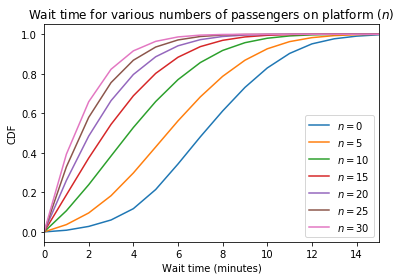

In [9]:
rlc = mtb.RedLineCalculator(OBSERVED_GAP_TIMES, passenger_data)

for n_passengers in range(0, 31, 5):
    Y = rlc.estimate_Y(n_passengers)
    Y.to_cdf().plot(label='$n = %d$' % n_passengers)

plt.ylabel('CDF')
plt.xlabel('Wait time (minutes)')
plt.xlim(0, 15)
plt.title('Wait time for various numbers of passengers on platform ($n$)')
plt.legend()
plt.show()

## Decision Analysis

Downey can afford to wait 15 minutes for the red line. If he waits longer, he will miss his subsequent connection at South Station. Now we need to know the probability of waiting more than 15 minutes given a number of passengers on the platform.

There is a problem: we have very little information about long delays (> 15 minutes), so we need another source of information to estimate their probability. Downey says he has observed 3 long delays in his last 220 commutes. We can incorporate these delays to $Z_b$ to be used in the `RedLineCalculator`.

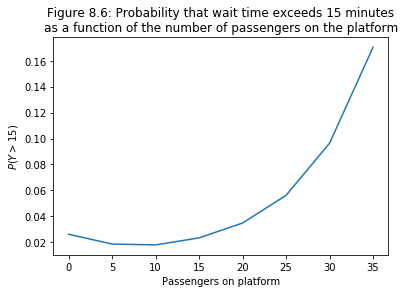

In [10]:
# Reconstruct a sample from Z that includes 220 normal times and the three long delays.
Zb_sample = Zb.sample(220).tolist() + [30, 40, 50]               # Biased sample.
Zb_long = mtb.PMF.from_kde(Zb_sample, np.arange(1, 61))          # Sample -> KDE -> PMF.
Z_long = mtb.PMF(Zb_long.hypos, Zb_long.probs / Zb_long.hypos)   # Biased PMF -> unbiased PMF.
assert np.isnan(Z_long).any() == False

# Use the new Z PMF to compute P(Y > 15) for various numbers of passengers.
rlc = mtb.RedLineCalculator(Z_long, passenger_data)
N, P = list(range(0, 36, 5)), []
for n_passengers in N:
    Y = rlc.estimate_Y(n_passengers)
    P.append(Y.to_cdf() > 15)
    
plt.plot(N, P)
plt.xlabel('Passengers on platform')
plt.ylabel('$P(Y > 15)$')
plt.title('Figure 8.6: Probability that wait time exceeds 15 minutes\nas a function of the number of passengers on the platform')
plt.show()

In [11]:
'Done'

'Done'